Morfología Matemática en Procesamiento de Imagen

En este notebook se hace uso de herramientas de morfología matemática para limpiar una imagen de elementos no deseados y poder así contar los objectos que _Pac-Man_ aún tiene pendientes por recoger.

In [1]:
# Carga de módulos y funciones auxiliares
import imageio
import matplotlib.pyplot as plt
import numpy as np

from skimage import color, feature, morphology, util, segmentation

def imshow(image, figsize=(7,7), cmap=plt.cm.gray, title=None):
    """
    Función para representar imágenes.
    """
    fig, ax = plt.subplots(figsize=figsize)

    if title:
        fig.suptitle(title, fontsize=12)

    ax.imshow(image, cmap=cmap)
    ax.set_axis_off()

    plt.show()

def imcmp(image_a, image_b, contour_b=None,
          title_a='original', title_b='filtered',
          figsize=(12, 6), cmap=plt.cm.gray, title=None):
    """
    Función para comparar dos imágenes una junto a otra.
    """
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=figsize, sharex=True, sharey=True)

    if title:
        fig.suptitle(title, fontsize=12)

    ax1.imshow(image_a, cmap=cmap)
    ax1.set_title(title_a)
    ax1.set_axis_off()

    ax2.imshow(image_b, cmap=cmap)
    ax2.set_title(title_b)
    ax2.set_axis_off()

    if contour_b is not None:
        ax2.contour(contour_b, [0.5], colors='r')

    plt.show()

def count_dots(image, show_image=True, verbose=True, figsize=(7,7), cmap=plt.cm.gray,) -> int:
    """
    Función para identificar y contar puntos en una imagen.
    """

    """
    Se usa el método blob_log para identificar los puntos de la imagen
    Threshold: permite identificar puntos de menor intensidad
    Overlap: permite establecer la cantidad de solape que puede existir entre puntos
    """
    coords_orig = feature.blob_log(image, min_sigma=4, max_sigma=15, threshold=0.1, overlap=0)

    # Postproceso -> Se eliminan los puntos detectados en los bordes de la imagen
    shape = image.shape
    coords_orig = list(filter(lambda x: 0 < x[1] < shape[0] and 0 < x[0] < shape[1], coords_orig))

    number_of_dots = len(coords_orig)

    if show_image:
        fix, ax = plt.subplots(figsize=figsize)
        ax.set_axis_off()

        # Variable para contar el número de puntos con un determinado radio
        radii_count = dict(map(lambda x: (x[2], 0), coords_orig))

        for dot in coords_orig:
            y, x, r = dot
            radii_count[r] += 1
            ax.add_patch(plt.Circle((x, y), r+.5, color='red', linewidth=1, fill=False))
        
        plt.imshow(image, cmap=cmap)
        plt.show()
    
        if verbose:
            print(f"Resumen radios: {radii_count}")
    
    if verbose:
        print(f"Número de puntos identificados en la imagen: {number_of_dots}")

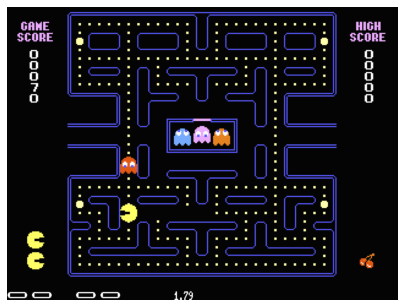

In [2]:
image_name = 'Pac-Man.png'

# Carga del contenido de la imagen
image = imageio.imread(image_name)
imshow(image, cmap=None)

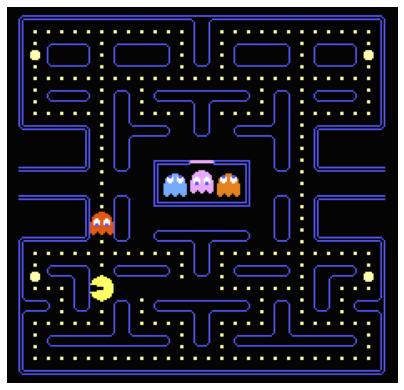

In [3]:
# Se recorta la imagen para eliminar los elementos externos al tablero
crop_width = (
    (0, 50),    # Altura
    (150, 150), # Anchura
    (0, 0)      # Profundidad
)
image = util.crop(image, crop_width)
imshow(image)

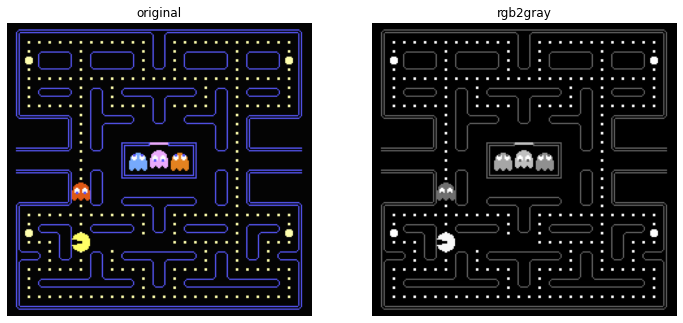

In [4]:
# Se convierte la imagen a escala de grises
image_gray = color.rgb2gray(image)
imcmp(image, image_gray, title_b='rgb2gray')

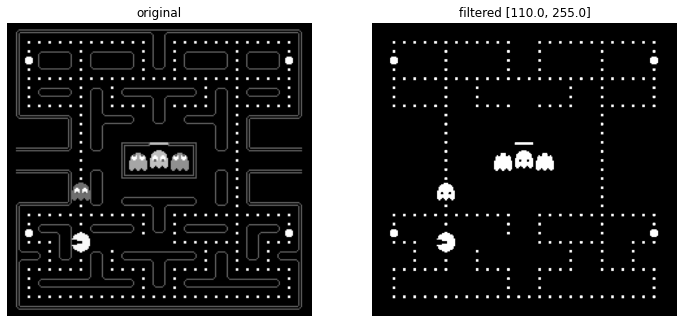

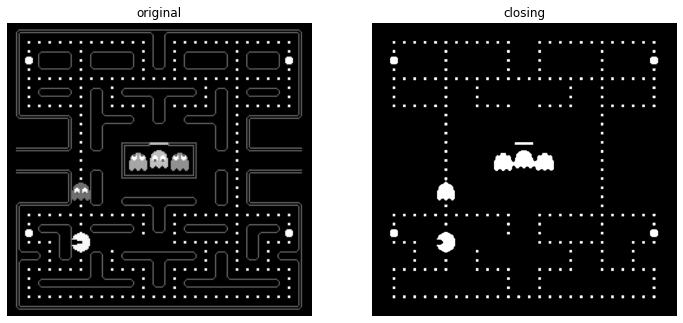

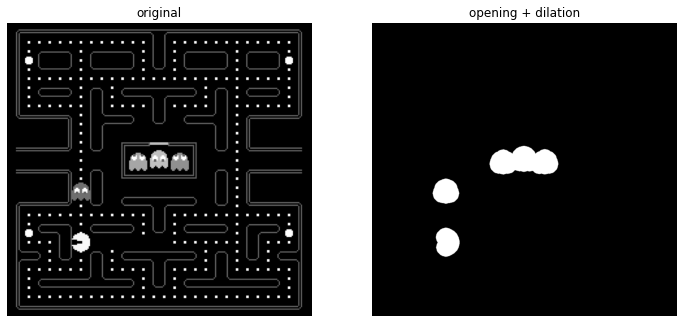

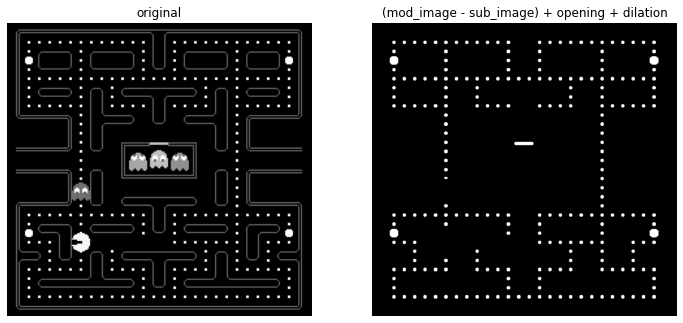

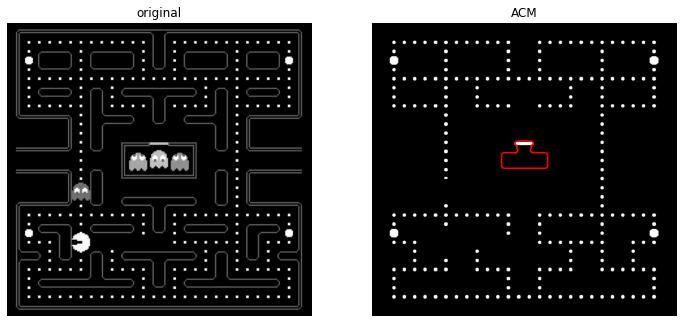

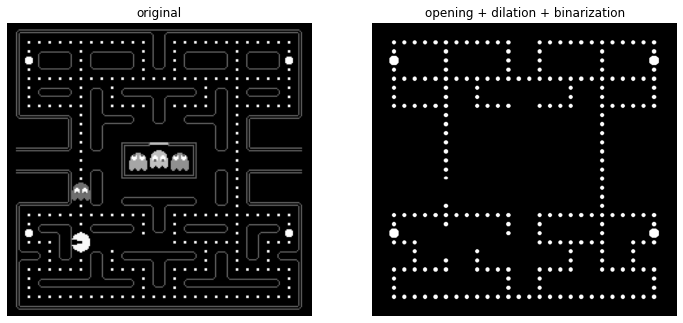

In [5]:
# Se copia la imagen para aplicar las transformaciones sin destruir la imagen de referencia
mod_image = image_gray.copy() * 255.

# 1. Se limitan los umbrales de la imagen para aislar lo máximo posible los puntos
min_limit, max_limit = 110., 255.
mod_image = (mod_image >= min_limit) * (mod_image <= max_limit)
mod_image = np.asarray(mod_image, dtype=int) * 255
imcmp(image_gray, mod_image, title_b=f"filtered [{min_limit}, {max_limit}]")

# 2. Aplicamos una dilatación para engordar los puntos que se han mantenido
selem = morphology.disk(4)
mod_image = morphology.closing(mod_image, selem)
imcmp(image_gray, mod_image, title_b='closing')

# 3. Apertura + dilatación para obtener una imagen que permita substraer fantasmas
selem = morphology.disk(12)
sub_image = morphology.opening(mod_image, selem)
sub_image = morphology.dilation(sub_image, selem)
imcmp(image_gray, sub_image, title_b='opening + dilation')

# 4. Se resta la imagen anterior a la imagen que se venía procesando
mod_image = mod_image - sub_image
mod_image[mod_image < 0] = 0

selem = morphology.disk(1)
mod_image = morphology.opening(mod_image, selem)
mod_image = morphology.dilation(mod_image, selem)

imcmp(image_gray, mod_image, title_b='(mod_image - sub_image) + opening + dilation')

# 5. Se elimina ahora el rectángulo que queda en el centro de la imagen
# Dado que está muy aislado, sería sencillo eliminarlo estableciendo a 0
# en esa región de la imagen. Pero aprovechamos ACM para realizar esta tarea.

# Contorno inicial de la serpiente
init_snake = np.zeros(mod_image.shape, dtype=int)
init_snake[250:-300, 250:-250] = 1

# List with intermediate results for plotting the evolution
iterations = 100
gimage = segmentation.inverse_gaussian_gradient(mod_image)
snake = segmentation.morphological_geodesic_active_contour(gimage, iterations, init_snake,
                                                           smoothing=1, balloon=-1, threshold=0.8)

imcmp(image_gray, mod_image, contour_b=snake, title_b='ACM')

mod_image = mod_image - snake * 255
mod_image[mod_image < 0] = 0

# 6. Aplicamos de nuevo una apertura para eliminar los restos de la substracción anterior
# Añadimos un último paso para binarizar la imagen
selem = morphology.disk(1)
mod_image = morphology.opening(mod_image, selem)
mod_image = morphology.dilation(mod_image, selem)
mod_image = mod_image > 250
imcmp(image_gray, mod_image, title_b='opening + dilation + binarization')

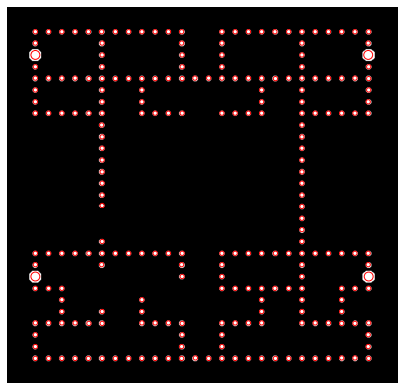

Resumen radios: {4.0: 229, 8.88888888888889: 4}
Número de puntos identificados en la imagen: 233


In [6]:
# Se cuentan los puntos que han quedado en la imagen tras ser filtrada
count_dots(mod_image)